# SUPERVISED MACHINE LEARNING MODEL SELECTION #


In [1]:
####################################################################################### INITIALIZING CURRENT_DIR ################################################################################
import os

def CURRENT_DIR():
    cwd = os.getcwd()
    return os.chdir(cwd[:(cwd.index("Eliza")+5)])

CURRENT_DIR()

print(os.getcwd())

c:\Users\dimas\Desktop\BECODE\PROJECTS\Project_MLDeployment_ImmoEliza


In [2]:
####################################################################################### LIBRARIES USED IN THIS NOTEBOOK ################################################################################

import pandas as pd
import seaborn as sns
import numpy as np
from typing import Optional, Union, Literal
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.impute import KNNImputer, SimpleImputer
import xgboost as xgb
from sklearn.pipeline import Pipeline
import os
from src.config import Config, DataProcessor, XGBOOSTUtilities

### GENERAL DESCRIPTION

The purpose of this notebook is to provide an insight into the multitude processes that I have gone through to create a supervised machine learning model that corresponds well to the gathered data that I have gathered. 

This project is a continuation of multiple iterations of ImmoEliza projects, whose objective is to approach the challenge of real estate property valuation by using data science methodology. You can always consult to other notebooks of that is contained in this repository or check other repositories that I have done under ImmoEliza project

 1. [Project Immobel - Exploratory Data Analysis on Belgium's Real Estate Market ](https://github.com/mfirdaus354/project-immobel)
 2. [Project Immo_Regression - My first attempt on generating supervised machine learning model using the data obtained through Project Immobel](https://github.com/mfirdaus354/project_immo_regression)

Let's start with seeing how the price distribution of single residential houses from different provinces of Belgium


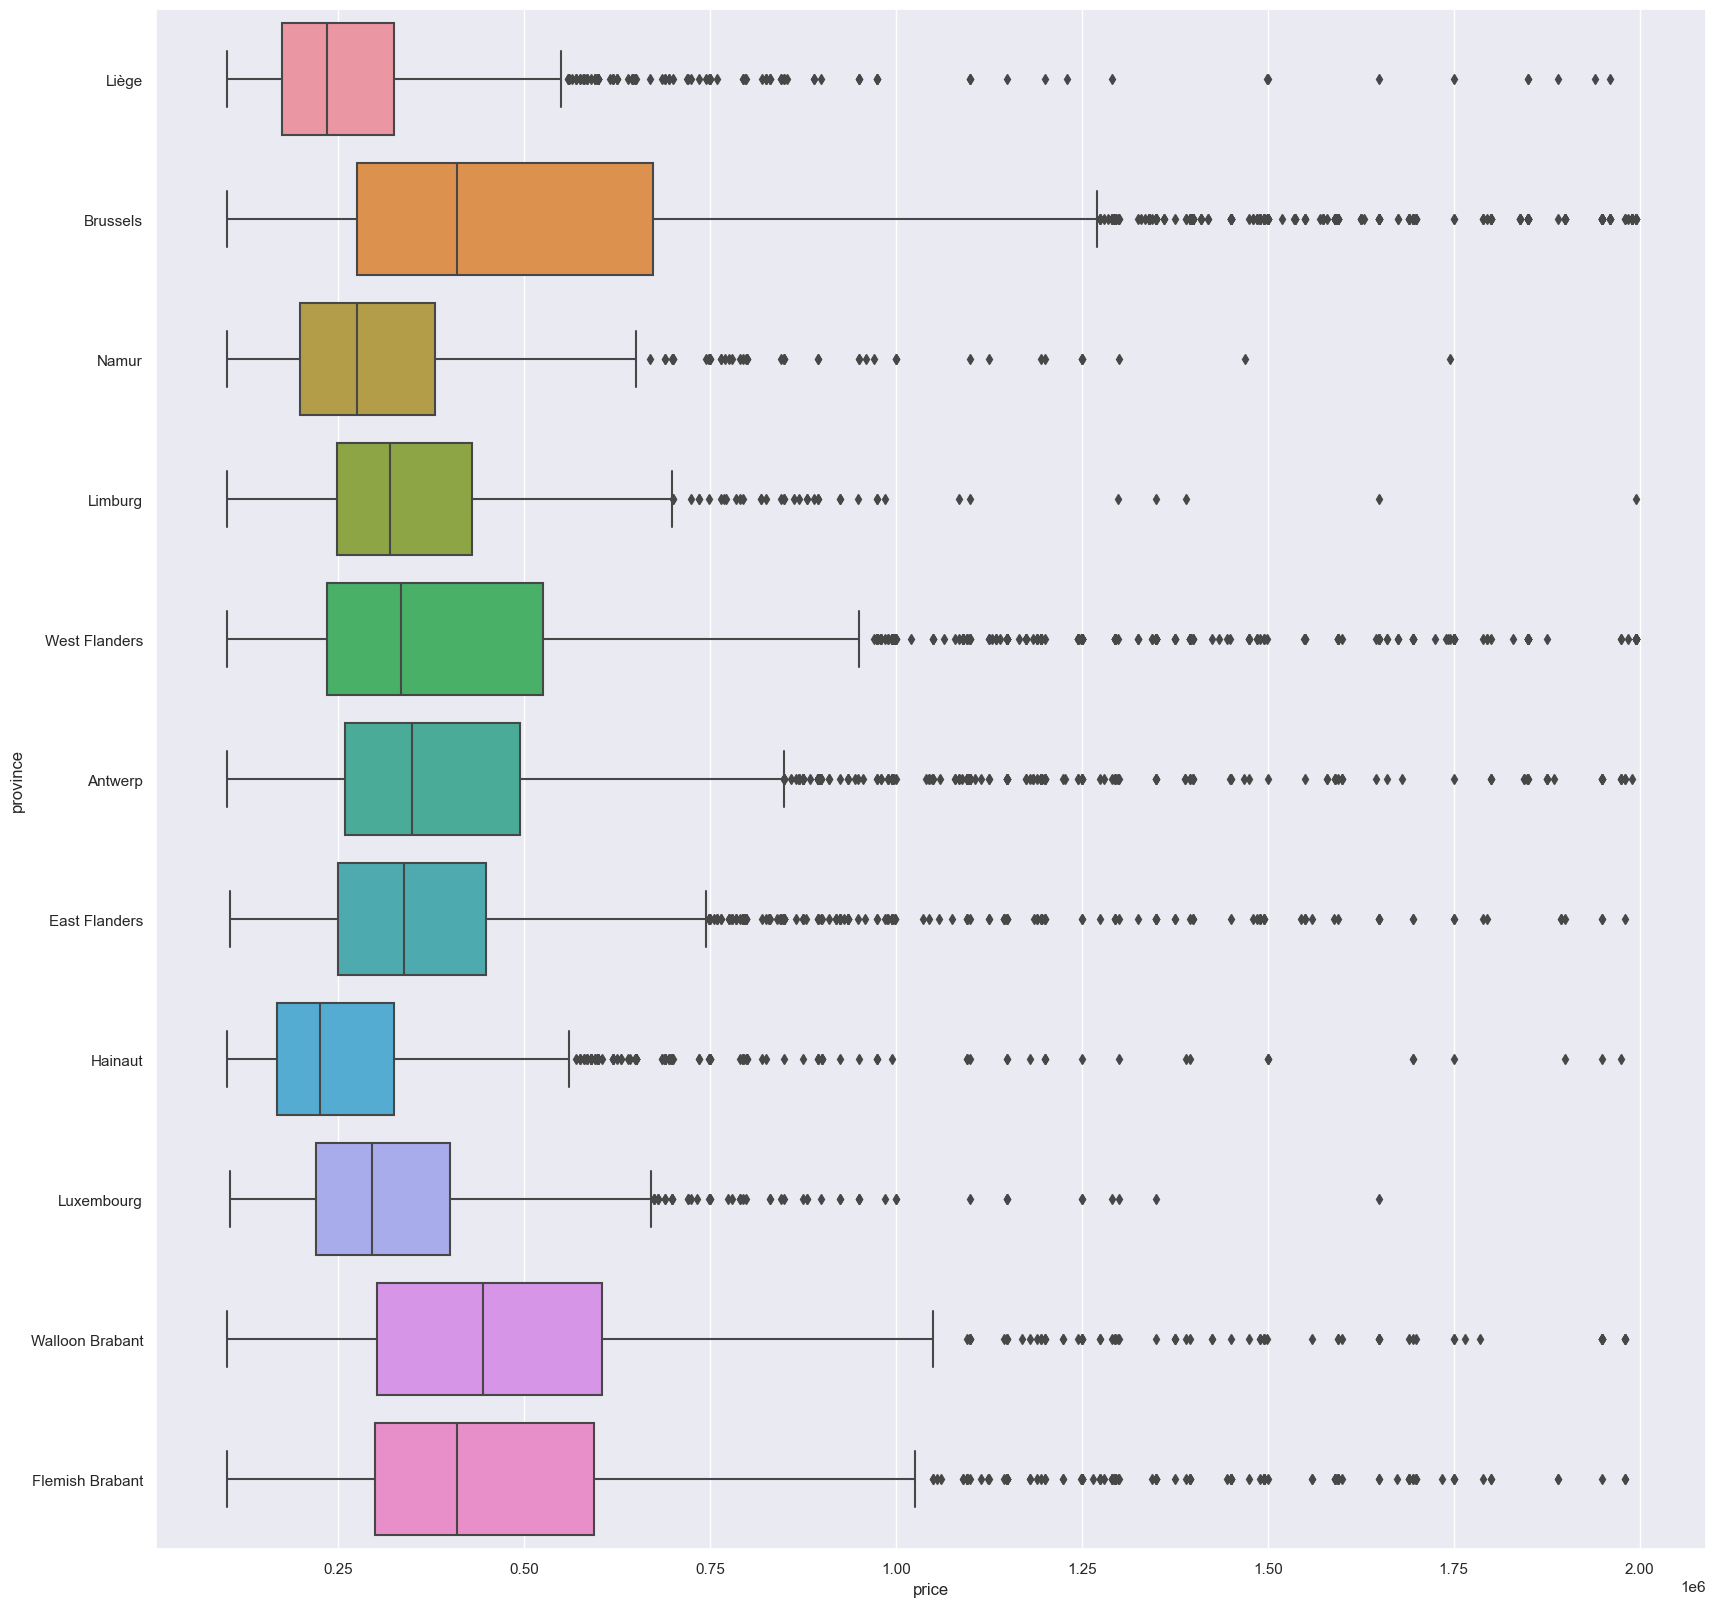

As you can see from the graph above that even after removing extreme outliers, the price distribution for a one single property type is widely distributed and it differs between provinces. This is a clear indicator that linear regression will never be able to be used as a basis of the generation of the supervised machine learning model that we will then used to generate a prediction of a housing price


After countless experiments with various result, I have decided to focus on generated prediction of house market prices using these variables
 1. price
 2. price per squaremeter
 3. plot area
 4. habitable surface
 5. land surface


In [3]:
####################################################################################### GETTING TO KNOW DF_MAIN ################################################################################

# import libaries
import pandas as pd
from src.config import DataProcessor


# loading data_forsale_new.csv into df_main
df_main = DataProcessor.load_data("data/data_forsale_new.csv", "csv")

# checking out on df_main
Config.expand_display(df_main.columns)
Config.expand_display(x="correlation betwween price and other variables", y=df_main[["price", "price_per_sqmeter", "plot_area", "habitable_surface", 
         "land_surface", "bedroom_count", "room_count", 'postalcode', 'district', 'province', 'region']].corr()["price"], )



Index(['address', 'bedroom_count', 'district', 'epc_score', 'habitable_surface', 'immo_status', 'immocode', 'land_surface', 'municipality', 'plot_area', 'postalcode', 'price', 'price_per_sqmeter', 'province', 'region', 'room_count', 'subtype', 'type'], dtype='object')

None

None

'correlation betwween price and other variables'

price                               1.00
price_per_sqmeter                   0.17
plot_area                           0.15
habitable_surface                   0.34
land_surface                        0.15
bedroom_count                       0.38
room_count                          0.38
postalcode                         -0.12
district                           -0.22
province                            0.14
region                              0.06
Name: price, dtype: float64

None

based on the calculated correlation value above, I have decided to use these variables as basis for my machine learning model
But in the end, I will use these columns:
 | Variable            | Target/Feature   | Correlation (Poisson) | 
 | :---                |       :---:      |         :---:         |
 | price               |       Target     |       1.00            | 
 | plot_area           |       Feature    |       0.15            | 
 | habitable_surface   |       Feature    |       0.34            | 
 | land_surface        |       Feature    |       0.15            | 
 | bedroom_count       |       Feature    |       0.38            | 
 | room_count          |       Feature    |       0.38            | 


#  TREE BOOSTED, NONLINEAR REGRESSION POWERED BY XGBREGRESSOR



After my experiments during Immo_Regression Project I have decided to solely focus on Multiple Non-linear Regression. Hoowever, there are a lot of factors that must be considered while venturing into generating a supervised machine learning model based on  Multiple Non-linear Regression. 

In this project I will solely focusing on Multiple Polynomial Non-Linear Regression by incorporating Gradient Descent Boosting Algorithm powered by XGBOOST. 

You can see different model iterations below

#### BASELINE MODEL

In [7]:
####################################################################################### GENERATING BASELINE MODEL ################################################################################

import os

def CURRENT_DIR():
    cwd = os.getcwd()
    return os.chdir(cwd[:(cwd.index("Eliza")+5)])

CURRENT_DIR()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as XGB
from sklearn.model_selection import  train_test_split, validation_curve, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from src.config import Config, DataProcessor, XGBOOSTUtilities
from sklearn.pipeline import Pipeline, make_pipeline

# Loading data_forsale_new.csv into df_main to generate df_set_one
df_set_one = DataProcessor.load_data(filepath='./data/data_forsale_new.csv', file_type="csv", usecols=["price", "plot_area", "habitable_surface", "bedroom_count", "land_surface", "room_count"])

# Apply log fit_transformation to the 'price' column
df_set_one['price'] = np.log1p(df_set_one['price'])

# Extract the features (X) and target (y)
X, y = DataProcessor.feature_target_config(df=df_set_one)

# reshape y
y = y.reshape(-1, 1)

# Create preprocessing_pipeline
degre_used= np.linspace(3, 8, num=1, endpoint=True, dtype=int)[0], order="F")
n_neigbors_used = np.linspace(1, 10, num=1, endpoint=True, dtype=int)[0])

preprocessing_pipeline = make_pipeline(
    KNNImputer(missing_values=np.nan, n_neighbors=n_neigbors_used),
    StandardScaler(with_std=True),
    PolynomialFeatures(degree=degre_used)
)

# Apply fit_transform on each step of the pipeline
X_preprocessed = preprocessing_pipeline[0].fit_transform(X)
y_preprocessed = preprocessing_pipeline[1].fit_transform(y)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
                X_preprocessed, y_preprocessed, test_size=0.20, random_state=42
            )

# Sort X_train and y_train based on X_train[:, 0]
sort_indices_train = np.argsort(X_train[:, 0])
X_train_sorted = X_train[sort_indices_train]
y_train_sorted = y_train[sort_indices_train]

# Sort X_test and y_test based on X_test[:, 0]
sort_indices_test = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sort_indices_test]
y_test_sorted = y_test[sort_indices_test]

# parameters= XGBOOSTUtilities.XGB_param()

param = {
    "n_estimators" : 100,
    "objective": "reg:squarederror",
    "min_child_weight": 2,
    "base_score": 0.4,
    "eval_metric": "rmse",
    "random_state": 452
}


xgb_reg = XGB.XGBRegressor(**param)

xgb_reg.fit(X_train_sorted, y_train_sorted, eval_set=[(X_train_sorted, y_train_sorted), (X_test_sorted, y_test_sorted)], verbose=True)

y_prediction = xgb_reg.predict(X_test_sorted)


[0]	validation_0-rmse:0.78159	validation_1-rmse:0.88384
[1]	validation_0-rmse:0.58814	validation_1-rmse:0.74770
[2]	validation_0-rmse:0.45619	validation_1-rmse:0.66684
[3]	validation_0-rmse:0.37230	validation_1-rmse:0.62541
[4]	validation_0-rmse:0.31495	validation_1-rmse:0.60738
[5]	validation_0-rmse:0.27430	validation_1-rmse:0.60394
[6]	validation_0-rmse:0.24802	validation_1-rmse:0.59625
[7]	validation_0-rmse:0.23421	validation_1-rmse:0.59268
[8]	validation_0-rmse:0.22525	validation_1-rmse:0.58864
[9]	validation_0-rmse:0.21428	validation_1-rmse:0.58954
[10]	validation_0-rmse:0.20598	validation_1-rmse:0.59454
[11]	validation_0-rmse:0.19791	validation_1-rmse:0.59781
[12]	validation_0-rmse:0.19469	validation_1-rmse:0.59918
[13]	validation_0-rmse:0.18871	validation_1-rmse:0.60111
[14]	validation_0-rmse:0.18542	validation_1-rmse:0.60363
[15]	validation_0-rmse:0.18336	validation_1-rmse:0.60623
[16]	validation_0-rmse:0.18157	validation_1-rmse:0.60754
[17]	validation_0-rmse:0.17966	validation

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


'The best iteration and the  R2 Scores is listed below'

,Results
Best_iteration,99.00
r2 train,0.99
r2 train after 5 validation,0.68
r2 test,0.67
r2 test after {n_cv} after validation,0.53


None

Mean Value of MPHE - Training 0.14692556964733405 Mean Value of MPHE - Validation 0.6118852138669802
The average of Mean Squared Error 0.3695325063472935


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.1s


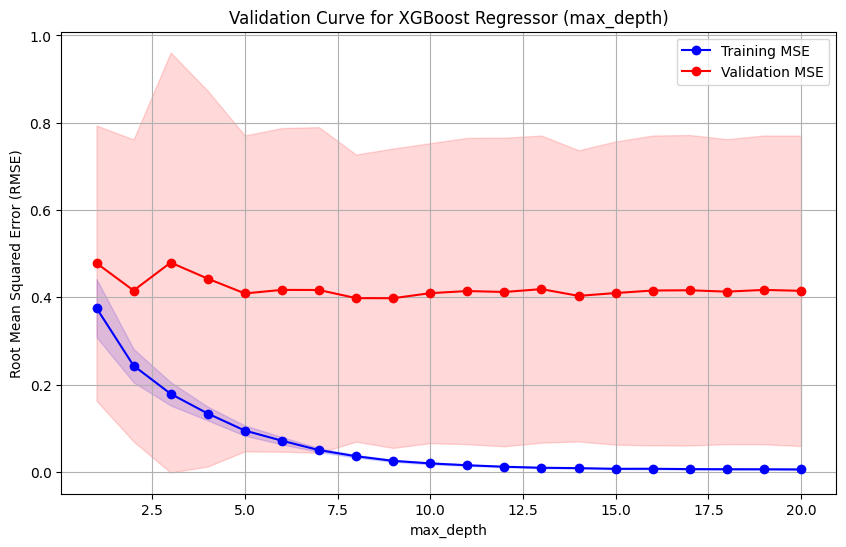

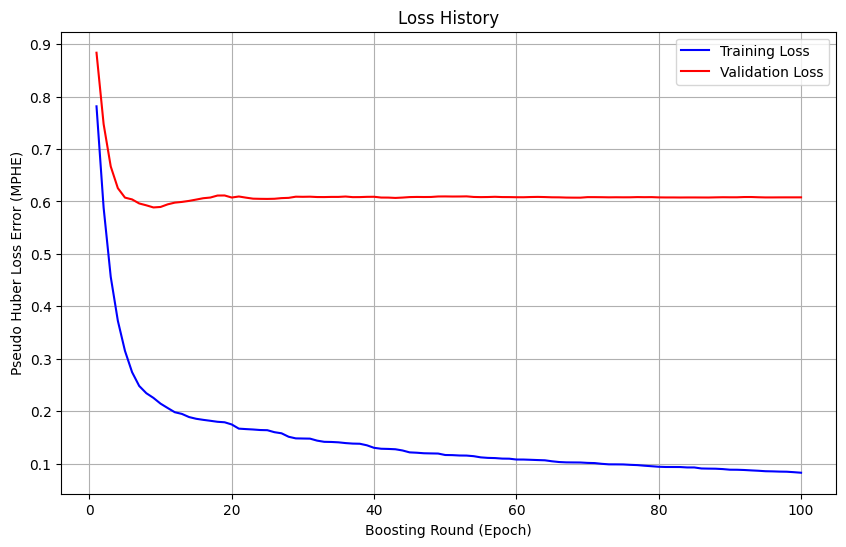

In [9]:
### BASELINE MODEL EVALUATION ### 

# generating evaluation result datasets
evaluation_results = xgb_reg.evals_result()

#evaluation matrix
best_iter = xgb_reg.best_iteration
training_scores_mphe = pd.DataFrame(evaluation_results["validation_0"])
validation_score_mphe = pd.DataFrame(evaluation_results["validation_1"])
mean_mphe_training = training_scores_mphe.values.mean()
mean_mphe_validation= validation_score_mphe.values.mean()

training_validation_df = pd.concat(objs=[training_scores_mphe, validation_score_mphe], axis=1)
n_cv = 5
r2_score_train= xgb_reg.score(X_train_sorted, y_train_sorted)
r2_cv_train = cross_val_score(xgb_reg, X_train_sorted, y_train_sorted, scoring="r2", cv=n_cv, error_score="raise", n_jobs=-1, verbose=2)
r2_score_test = xgb_reg.score(X_test_sorted, y_test_sorted)
r2_cv_test = cross_val_score(xgb_reg, X_test_sorted, y_test_sorted, scoring="r2", cv=n_cv, error_score="raise", n_jobs=-1, verbose=2)



mse  = mean_squared_error(y_true=y_test_sorted, y_pred=y_prediction, multioutput="raw_values")

score_df = pd.DataFrame.from_dict(data={
    "Best_iteration" : best_iter,
    "r2 train": r2_score_train,
    f"r2 train after {n_cv} validation": r2_cv_train.mean(),
    "r2 test": r2_score_test,
    "r2 test after {n_cv} after validation" : r2_cv_test.mean() 
},orient="index", columns=["Results"])
Config.expand_display(x= "The best iteration and the  R2 Scores is listed below", y=score_df)
print(f"Mean Value of MPHE - Training {mean_mphe_training}", f"Mean Value of MPHE - Validation {mean_mphe_validation}")
print(f"The average of Mean Squared Error {mse.mean()}")


### VISUALIZING PERFORMANCE

# Calculate validation curve for "max_depth" hyperparameter
param_range = np.arange(1, 21)
train_scores, test_scores = validation_curve(
    xgb_reg, X_train_sorted, y_train_sorted.ravel(), param_name="max_depth", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", verbose=1
)

# Convert the negative mean squared errors to positive root mean squared errors (RMSE)
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Calculate the mean and standard deviation of the RMSE scores across the folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training MSE", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, label="Validation MSE", color="red", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="red")
plt.xlabel("max_depth")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Validation Curve for XGBoost Regressor (max_depth)")
plt.legend()
plt.grid(True)
plt.show()

# Extract the training and validation loss values
train_loss = evaluation_results['validation_0']['rmse']
val_loss = evaluation_results['validation_1']['rmse']

# Get the number of boosting rounds (epochs)
num_rounds = len(train_loss)

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), train_loss, label="Training Loss", color="blue")
plt.plot(range(1, num_rounds + 1), val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Round (Epoch)")
plt.ylabel("Pseudo Huber Loss Error (MPHE)")
plt.title("Loss History")
plt.legend()
plt.grid(True)
plt.show()




Here are the steps that I have taken to implement the XGBOOST algorith in to the Multiple Polynomial Non-Linear Regression model
 1. Load the dataset into a main dataframe called df_set_one using Config.DataProcessor.feature_target_config 
 2. Split the target and features using Config.DataProcessor.feature_target_config module
 3. Create a preprocessing pipeline that can execute these 3 data preprocessing procedures:
     - Processing missing values (np.NaN) by using sklearn.impute KNNImputer, assigining a evenly generated random value within the range of 1 to 10 to the n_neighbors parameter
     - Scaling the distribution of the data using sklearn.preprocessing.StandardScaler
     - Fit and transform the scaled dataset with no missing values using sklearn.preprocessing.PolynomialFeatures, assigining a evenly generated random value within the range of 3 to 8 to the degree parameter 
 4. Transfrom the target and features using the preprocessing pipeline 
 5. Load and fit regression model by calling XGB.XGBRegressor(), passing only this parameters
    - n_estimators" : 100,
    - objective": "reg:squarederror",
    - min_child_weight": 2,
    - base_score": 0.4,
    - eval_metric": "rmse",
    - random_state": 452
 6. Generate the predicted values
 7. Generate evaluation scores

The Base Model clearly shows an typical symptoms of overfitting
 1. There is a significamt gap between accuracy (R2 Score) score during training and validation phases 
 2. There is a huge gap of errors during training and validation phases 

#### MODEL 1 - WITH HYPERPARAMETER TUNING

In [11]:
############ GENERATING MODEL 1

import os

def CURRENT_DIR():
    cwd = os.getcwd()
    return os.chdir(cwd[:(cwd.index("Eliza")+5)])

CURRENT_DIR()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as XGB
from sklearn.model_selection import  train_test_split, validation_curve, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import KNNImputer
from src.config import Config, DataProcessor, XGBOOSTUtilities
from sklearn.pipeline import Pipeline, make_pipeline

# Loading data_forsale_new.csv into df_main to generate df_set_one
df_set_one = DataProcessor.load_data(filepath='./data/data_forsale_new.csv', file_type="csv", usecols=["price", "plot_area", "habitable_surface", "bedroom_count", "land_surface", "room_count"])

# Apply log fit_transformation to the 'price' column
df_set_one['price'] = np.log1p(df_set_one['price'])

# Extract the features (X) and target (y)
X, y = DataProcessor.feature_target_config(df=df_set_one)

# reshape y
y = y.reshape(-1, 1)

# Create preprocessing_pipeline
preprocessing_pipeline = make_pipeline(
    KNNImputer(missing_values=np.nan, n_neighbors=np.linspace(1, 10, num=1, endpoint=True, dtype=int)[0]),
    StandardScaler(with_std=True),
    PolynomialFeatures(degree=10, order="F")
)

# Apply fit_transform on each step of the pipeline
X_preprocessed = preprocessing_pipeline[0].fit_transform(X)
y_preprocessed = preprocessing_pipeline[1].fit_transform(y)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
                X_preprocessed, y_preprocessed, test_size=0.20, random_state=42
            )

# Sort X_train and y_train based on X_train[:, 0]
sort_indices_train = np.argsort(X_train[:, 0])
X_train_sorted = X_train[sort_indices_train]
y_train_sorted = y_train[sort_indices_train]

# Sort X_test and y_test based on X_test[:, 0]
sort_indices_test = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sort_indices_test]
y_test_sorted = y_test[sort_indices_test]

# parameters= XGBOOSTUtilities.XGB_param()

param = {
    "n_estimators":1000,
    "booster": "gbtree",
    "tree_method": "hist",
    "learning_rate": 0.01,
    "max_depth": 5,
    "subsample": 0.5,
    "sampling_method": "uniform",
    "colsample_bytree": 0.4,
    "gamma": 0.1,
    "reg_alpha": 0.001,
    "reg_lambda": 0.1,
    "objective": "reg:squarederror",
    "min_child_weight": 2,
    "base_score": 0.4,
    "eval_metric": "rmse",
    "random_state": 452,
    "validate_parameters": 1,
}


# load fit predict regression model
xgb_reg = XGB.XGBRegressor(**param)
xgb_reg.fit(X_train_sorted, y_train_sorted, eval_set=[(X_train_sorted, y_train_sorted), (X_test_sorted, y_test_sorted)], verbose=True)
y_prediction = xgb_reg.predict(X=X_test_sorted)




[0]	validation_0-rmse:1.05899	validation_1-rmse:1.11849
[1]	validation_0-rmse:1.05289	validation_1-rmse:1.11311
[2]	validation_0-rmse:1.04746	validation_1-rmse:1.10835
[3]	validation_0-rmse:1.03837	validation_1-rmse:1.09983
[4]	validation_0-rmse:1.02970	validation_1-rmse:1.09140
[5]	validation_0-rmse:1.02404	validation_1-rmse:1.08607
[6]	validation_0-rmse:1.01856	validation_1-rmse:1.08111
[7]	validation_0-rmse:1.01277	validation_1-rmse:1.07617
[8]	validation_0-rmse:1.00735	validation_1-rmse:1.07150
[9]	validation_0-rmse:1.00207	validation_1-rmse:1.06682
[10]	validation_0-rmse:0.99362	validation_1-rmse:1.05933
[11]	validation_0-rmse:0.98837	validation_1-rmse:1.05476
[12]	validation_0-rmse:0.98443	validation_1-rmse:1.05127
[13]	validation_0-rmse:0.97904	validation_1-rmse:1.04664
[14]	validation_0-rmse:0.97431	validation_1-rmse:1.04256
[15]	validation_0-rmse:0.96606	validation_1-rmse:1.03441
[16]	validation_0-rmse:0.96216	validation_1-rmse:1.03124
[17]	validation_0-rmse:0.95367	validation

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


'The best iteration and the  R2 Scores is listed below'

,Results
Best_iteration,999.00
r2 train,0.93
r2 train after 5 validation,0.67
r2 test,0.74
r2 test after {n_cv} after validation,0.49


None

Mean Value of MPHE - Training 0.3791881002699373 Mean Value of MPHE - Validation 0.5970134230724168
The average of Mean Squared Error 0.2917067625391574


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   57.5s


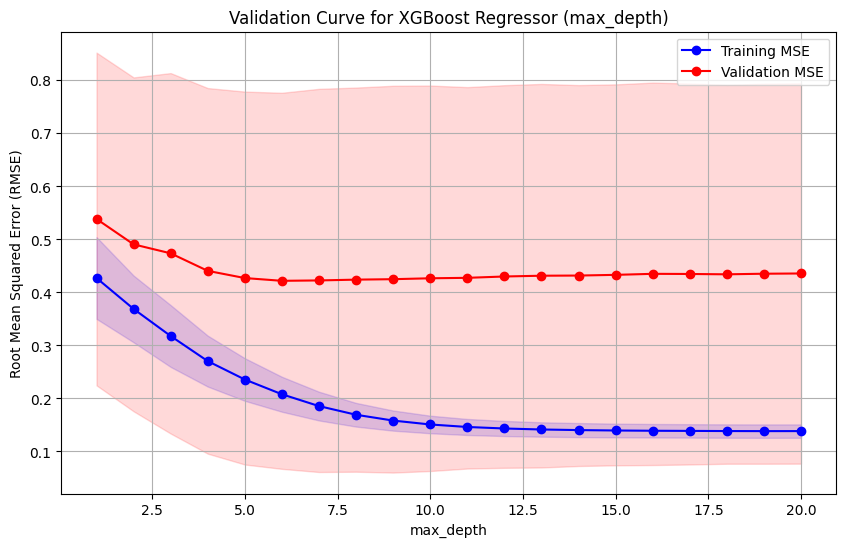

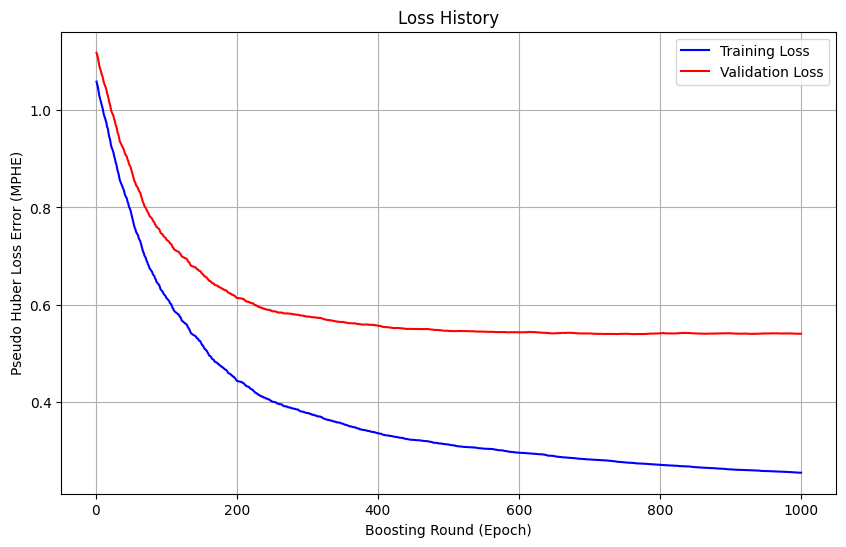

In [13]:
### MODEL 1 EVALUATION ### 

# generating evaluation result datasets
evaluation_results = xgb_reg.evals_result()

#evaluation matrix
best_iter = xgb_reg.best_iteration
training_scores_mphe = pd.DataFrame(evaluation_results["validation_0"])
validation_score_mphe = pd.DataFrame(evaluation_results["validation_1"])
mean_mphe_training = training_scores_mphe.values.mean()
mean_mphe_validation= validation_score_mphe.values.mean()

training_validation_df = pd.concat(objs=[training_scores_mphe, validation_score_mphe], axis=1)
n_cv = 5
r2_score_train= xgb_reg.score(X_train_sorted, y_train_sorted)
r2_cv_train = cross_val_score(xgb_reg, X_train_sorted, y_train_sorted, scoring="r2", cv=n_cv, error_score="raise", n_jobs=-1, verbose=2)
r2_score_test = xgb_reg.score(X_test_sorted, y_test_sorted)
r2_cv_test = cross_val_score(xgb_reg, X_test_sorted, y_test_sorted, scoring="r2", cv=n_cv, error_score="raise", n_jobs=-1, verbose=2)



mse  = mean_squared_error(y_true=y_test_sorted, y_pred=y_prediction, multioutput="raw_values")

score_df = pd.DataFrame.from_dict(data={
    "Best_iteration" : best_iter,
    "r2 train": r2_score_train,
    f"r2 train after {n_cv} validation": r2_cv_train.mean(),
    "r2 test": r2_score_test,
    "r2 test after {n_cv} after validation" : r2_cv_test.mean() 
},orient="index", columns=["Results"])
Config.expand_display(x= "The best iteration and the  R2 Scores is listed below", y=score_df)
print(f"Mean Value of MPHE - Training {mean_mphe_training}", f"Mean Value of MPHE - Validation {mean_mphe_validation}")
print(f"The average of Mean Squared Error {mse.mean()}")


### VISUALIZING PERFORMANCE

# Calculate validation curve for "max_depth" hyperparameter
param_range = np.arange(1, 21)
train_scores, test_scores = validation_curve(
    xgb_reg, X_train_sorted, y_train_sorted.ravel(), param_name="max_depth", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", verbose=1
)

# Convert the negative mean squared errors to positive root mean squared errors (RMSE)
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Calculate the mean and standard deviation of the RMSE scores across the folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training MSE", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, label="Validation MSE", color="red", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="red")
plt.xlabel("max_depth")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Validation Curve for XGBoost Regressor (max_depth)")
plt.legend()
plt.grid(True)
plt.show()

# Extract the training and validation loss values
train_loss = evaluation_results['validation_0']['rmse']
val_loss = evaluation_results['validation_1']['rmse']

# Get the number of boosting rounds (epochs)
num_rounds = len(train_loss)

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), train_loss, label="Training Loss", color="blue")
plt.plot(range(1, num_rounds + 1), val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Round (Epoch)")
plt.ylabel("Pseudo Huber Loss Error (MPHE)")
plt.title("Loss History")
plt.legend()
plt.grid(True)
plt.show()



UPDATE 

 1. Added this following hypertuned parameters
    - "n_estimators":1000
    - "booster": "gbtree"
    - "tree_method": "hist"
    - "learning_rate": 0.01
    - "max_depth": 5
    - "subsample": 0.5
    - "sampling_method": "uniform"
    - "colsample_bytree": 0.4
    - "gamma": 0.1
    - "reg_alpha": 0.001
    - "reg_lambda": 0.1
    - "objective": "reg:squarederror"
    - "min_child_weight": 2
    - "base_score": 0.4
    - "eval_metric": "rmse"
    - "random_state": 452
    - "validate_parameters": 1

#### MODEL 2 - WITH HYPERPARAMETER TUNING

In [14]:
############ GENERATING MODEL 2

import os

def CURRENT_DIR():
    cwd = os.getcwd()
    return os.chdir(cwd[:(cwd.index("Eliza")+5)])

CURRENT_DIR()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as XGB
from sklearn.model_selection import  train_test_split, validation_curve, cross_val_score, KFold
from src.config import DataProcessor, XGBOOSTUtilities
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import KNNImputer
from src.config import Config, DataProcessor
from sklearn.pipeline import Pipeline, make_pipeline

# Loading data_forsale_new.csv into df_main to generate df_set_one
df_set_one = DataProcessor.load_data(filepath='./data/data_forsale_new.csv', file_type="csv", usecols=["price", "plot_area", "habitable_surface", "bedroom_count", "land_surface", "room_count"])

# Apply log fit_transformation to the 'price' column
df_set_one['price'] = np.log1p(df_set_one['price'])

# Extract the features (X) and target (y)
X, y = DataProcessor.feature_target_config(df=df_set_one)

# reshape y
y = y.reshape(-1, 1)

# Create preprocessing_pipeline
preprocessing_pipeline = make_pipeline(
    KNNImputer(missing_values=np.nan, n_neighbors=np.linspace(1, 10, num=1, endpoint=True, dtype=int)[0]),
    StandardScaler(with_std=True),
    PolynomialFeatures(degree=10, order="F")
)

# Apply fit_transform on each step of the pipeline
X_preprocessed = preprocessing_pipeline[0].fit_transform(X)
y_preprocessed = preprocessing_pipeline[1].fit_transform(y)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
                X_preprocessed, y_preprocessed, test_size=0.20, random_state=42
            )

# Sort X_train and y_train based on X_train[:, 0]
sort_indices_train = np.argsort(X_train[:, 0])
X_train_sorted = X_train[sort_indices_train]
y_train_sorted = y_train[sort_indices_train]

# Sort X_test and y_test based on X_test[:, 0]
sort_indices_test = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sort_indices_test]
y_test_sorted = y_test[sort_indices_test]

# parameters= XGBOOSTUtilities.XGB_param()

param = {
    "n_estimators":1000,
    "booster": "gbtree",
    "learning_rate":0.01,
    "tree_method": "hist",
    "max_depth": 10,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    "sampling_method": "uniform",
    "gamma": 0.1,
    "reg_alpha": 5.5,
    "reg_lambda": 10.50,
    "objective": "reg:pseudohubererror",
    "min_child_weight": 54,
    "eval_metric": "mphe", 
    "random_state": 15615,
    "huber_slope": np.linspace(start=10.0, stop=15.0, num=1, endpoint=True, dtype=float).tolist()[0],
    "validate_parameters": 1,
}

# load fit predict regression model
xgb_reg = XGB.XGBRegressor(**param)
xgb_reg.fit(X_train_sorted, y_train_sorted, eval_set=[(X_train_sorted, y_train_sorted), (X_test_sorted, y_test_sorted)], verbose=True)
y_prediction = xgb_reg.predict(X=X_test_sorted)



[0]	validation_0-mphe:0.58199	validation_1-mphe:0.61555
[1]	validation_0-mphe:0.57249	validation_1-mphe:0.60605
[2]	validation_0-mphe:0.56597	validation_1-mphe:0.59965
[3]	validation_0-mphe:0.55648	validation_1-mphe:0.59035
[4]	validation_0-mphe:0.55150	validation_1-mphe:0.58544
[5]	validation_0-mphe:0.54248	validation_1-mphe:0.57648
[6]	validation_0-mphe:0.53697	validation_1-mphe:0.57121
[7]	validation_0-mphe:0.52820	validation_1-mphe:0.56240
[8]	validation_0-mphe:0.52234	validation_1-mphe:0.55666
[9]	validation_0-mphe:0.51770	validation_1-mphe:0.55212
[10]	validation_0-mphe:0.50943	validation_1-mphe:0.54380
[11]	validation_0-mphe:0.50132	validation_1-mphe:0.53557
[12]	validation_0-mphe:0.49585	validation_1-mphe:0.53022
[13]	validation_0-mphe:0.49102	validation_1-mphe:0.52562
[14]	validation_0-mphe:0.48318	validation_1-mphe:0.51792
[15]	validation_0-mphe:0.47563	validation_1-mphe:0.51026
[16]	validation_0-mphe:0.47156	validation_1-mphe:0.50627
[17]	validation_0-mphe:0.46420	validation

In [ ]:
### MODEL EVALUATION ### 

# generating evaluation result datasets
evaluation_results = xgb_reg.evals_result()

#evaluation matrix
best_iter = xgb_reg.best_iteration
training_scores_mphe = pd.DataFrame(evaluation_results["validation_0"])
validation_score_mphe = pd.DataFrame(evaluation_results["validation_1"])
mean_mphe_training = training_scores_mphe.values.mean()
mean_mphe_validation= validation_score_mphe.values.mean()

training_validation_df = pd.concat(objs=[training_scores_mphe, validation_score_mphe], axis=1)
n_cv = 5
r2_score_train= xgb_reg.score(X_train_sorted, y_train_sorted)
r2_cv_train = cross_val_score(xgb_reg, X_train_sorted, y_train_sorted, scoring="r2", cv=n_cv, error_score="raise", n_jobs=-1, verbose=2)
r2_score_test = xgb_reg.score(X_test_sorted, y_test_sorted)
r2_cv_test = cross_val_score(xgb_reg, X_test_sorted, y_test_sorted, scoring="r2", cv=n_cv, error_score="raise", n_jobs=-1, verbose=2)



mse  = mean_squared_error(y_true=y_test_sorted, y_pred=y_prediction, multioutput="raw_values")

score_df = pd.DataFrame.from_dict(data={
    "Best_iteration" : best_iter,
    "r2 train": r2_score_train,
    f"r2 train after {n_cv} validation": r2_cv_train.mean(),
    "r2 test": r2_score_test,
    "r2 test after {n_cv} after validation" : r2_cv_test.mean() 
},orient="index", columns=["Results"])
Config.expand_display(x= "The best iteration and the  R2 Scores is listed below", y=score_df)
print(f"Mean Value of MPHE - Training {mean_mphe_training}", f"Mean Value of MPHE - Validation {mean_mphe_validation}")
print(f"The average of Mean Squared Error {mse.mean()}")


### VISUALIZING PERFORMANCE

# Calculate validation curve for "max_depth" hyperparameter
param_range = np.arange(1, 21)
train_scores, test_scores = validation_curve(
    xgb_reg, X_train_sorted, y_train_sorted.ravel(), param_name="max_depth", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", verbose=1
)

# Convert the negative mean squared errors to positive root mean squared errors (RMSE)
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Calculate the mean and standard deviation of the RMSE scores across the folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training MSE", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, label="Validation MSE", color="red", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="red")
plt.xlabel("max_depth")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Validation Curve for XGBoost Regressor (max_depth)")
plt.legend()
plt.grid(True)
plt.show()

# Extract the training and validation loss values
train_loss = evaluation_results['validation_0']['mphe']
val_loss = evaluation_results['validation_1']['mphe']

# Get the number of boosting rounds (epochs)
num_rounds = len(train_loss)

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), train_loss, label="Training Loss", color="blue")
plt.plot(range(1, num_rounds + 1), val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Round (Epoch)")
plt.ylabel("Pseudo Huber Loss Error (MPHE)")
plt.title("Loss History")
plt.legend()
plt.grid(True)
plt.show()


UPDATE

Pass this parameter
 - "n_estimators":1000
 -  "booster": "gbtree",
 - "learning_rate":0.01,
 - "tree_method": "hist",
 - "max_depth": 10,
 - "subsample": 0.5,
 - "colsample_bytree": 0.5,
 - "sampling_method": "uniform",
 - "gamma": 0.1,
 - "reg_alpha": 5.5,
 - "reg_lambda": 10.50,
 - "objective": "reg:pseudohubererror",
 - "min_child_weight": 54,
 - "eval_metric": "mphe", 
 - "random_state": 15615,
 - "huber_slope": np.linspace(start=10.0, stop=15.0, num=1, endpoint=True, dtype=float).tolist()[0],
 - "validate_parameters": 1,


#### MODEL 3 - WITH HYPERPARAMETER TUNING

In [15]:
############ GENERATING MODEL 3

import os

def CURRENT_DIR():
    cwd = os.getcwd()
    return os.chdir(cwd[:(cwd.index("Eliza")+5)])

CURRENT_DIR()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as XGB
from sklearn.model_selection import  train_test_split, validation_curve, cross_val_score, KFold
from src.config import DataProcessor, XGBOOSTUtilities
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import KNNImputer
from src.config import Config, DataProcessor
from sklearn.pipeline import Pipeline, make_pipeline

# Loading data_forsale_new.csv into df_main to generate df_set_one
df_set_one = DataProcessor.load_data(filepath='./data/data_forsale_new.csv', file_type="csv", usecols=["price", "plot_area", "habitable_surface", "bedroom_count", "land_surface", "room_count"])

# Apply log fit_transformation to the 'price' column
df_set_one['price'] = np.log1p(df_set_one['price'])

# Extract the features (X) and target (y)
X, y = DataProcessor.feature_target_config(df=df_set_one)

# reshape y
y = y.reshape(-1, 1)

# Create preprocessing_pipeline
preprocessing_pipeline = make_pipeline(
    KNNImputer(missing_values=np.nan, n_neighbors=np.linspace(1, 10, num=1, endpoint=True, dtype=int)[0]),
    StandardScaler(with_std=True),
    PolynomialFeatures(degree=10, order="F")
)

# Apply fit_transform on each step of the pipeline
X_preprocessed = preprocessing_pipeline[0].fit_transform(X)
y_preprocessed = preprocessing_pipeline[1].fit_transform(y)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
                X_preprocessed, y_preprocessed, test_size=0.20, random_state=42
            )

# Sort X_train and y_train based on X_train[:, 0]
sort_indices_train = np.argsort(X_train[:, 0])
X_train_sorted = X_train[sort_indices_train]
y_train_sorted = y_train[sort_indices_train]

# Sort X_test and y_test based on X_test[:, 0]
sort_indices_test = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sort_indices_test]
y_test_sorted = y_test[sort_indices_test]

# parameters= XGBOOSTUtilities.XGB_param()

param = {

}

# load fit predict regression model
xgb_reg = XGB.XGBRegressor(**param)

# fit the regression model
xgb_reg.fit(X_train_sorted, y_train_sorted, eval_set=[(X_train_sorted, y_train_sorted), (X_test_sorted, y_test_sorted)], verbose=True)

# predict the possible prices
y_prediction = xgb_reg.predict(X=X_test_sorted)



[0]	validation_0-mphe:0.58171	validation_1-mphe:0.61552
[1]	validation_0-mphe:0.57178	validation_1-mphe:0.60583
[2]	validation_0-mphe:0.56205	validation_1-mphe:0.59634
[3]	validation_0-mphe:0.55251	validation_1-mphe:0.58703
[4]	validation_0-mphe:0.54312	validation_1-mphe:0.57785
[5]	validation_0-mphe:0.53391	validation_1-mphe:0.56880
[6]	validation_0-mphe:0.52488	validation_1-mphe:0.55996
[7]	validation_0-mphe:0.51603	validation_1-mphe:0.55126
[8]	validation_0-mphe:0.50736	validation_1-mphe:0.54277
[9]	validation_0-mphe:0.49889	validation_1-mphe:0.53444
[10]	validation_0-mphe:0.49055	validation_1-mphe:0.52625
[11]	validation_0-mphe:0.48242	validation_1-mphe:0.51825
[12]	validation_0-mphe:0.47444	validation_1-mphe:0.51040
[13]	validation_0-mphe:0.46658	validation_1-mphe:0.50272
[14]	validation_0-mphe:0.45891	validation_1-mphe:0.49519
[15]	validation_0-mphe:0.45139	validation_1-mphe:0.48781
[16]	validation_0-mphe:0.44397	validation_1-mphe:0.48058
[17]	validation_0-mphe:0.43670	validation

In [ ]:
### MODEL EVALUATION ### 

# generating evaluation result datasets
evaluation_results = xgb_reg.evals_result()

#evaluation matrix
best_iter = xgb_reg.best_iteration
training_scores_mphe = pd.DataFrame(evaluation_results["validation_0"])
validation_score_mphe = pd.DataFrame(evaluation_results["validation_1"])
mean_mphe_training = training_scores_mphe.values.mean()
mean_mphe_validation= validation_score_mphe.values.mean()

training_validation_df = pd.concat(objs=[training_scores_mphe, validation_score_mphe], axis=1)
n_cv = 5
r2_score_train= xgb_reg.score(X_train_sorted, y_train_sorted)
r2_cv_train = cross_val_score(xgb_reg, X_train_sorted, y_train_sorted, scoring="r2", cv=n_cv, error_score="raise", n_jobs=-1, verbose=2)
r2_score_test = xgb_reg.score(X_test_sorted, y_test_sorted)
r2_cv_test = cross_val_score(xgb_reg, X_test_sorted, y_test_sorted, scoring="r2", cv=n_cv, error_score="raise", n_jobs=-1, verbose=2)



mse  = mean_squared_error(y_true=y_test_sorted, y_pred=y_prediction, multioutput="raw_values")

score_df = pd.DataFrame.from_dict(data={
    "Best_iteration" : best_iter,
    "r2 train": r2_score_train,
    f"r2 train after {n_cv} validation": r2_cv_train.mean(),
    "r2 test": r2_score_test,
    "r2 test after {n_cv} after validation" : r2_cv_test.mean() 
},orient="index", columns=["Results"])
Config.expand_display(x= "The best iteration and the  R2 Scores is listed below", y=score_df)
print(f"Mean Value of MPHE - Training {mean_mphe_training}", f"Mean Value of MPHE - Validation {mean_mphe_validation}")
print(f"The average of Mean Squared Error {mse.mean()}")


### VISUALIZING PERFORMANCE

# Calculate validation curve for "max_depth" hyperparameter
param_range = np.arange(1, 21)
train_scores, test_scores = validation_curve(
    xgb_reg, X_train_sorted, y_train_sorted.ravel(), param_name="max_depth", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", verbose=1
)

# Convert the negative mean squared errors to positive root mean squared errors (RMSE)
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Calculate the mean and standard deviation of the RMSE scores across the folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training MSE", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, label="Validation MSE", color="red", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="red")
plt.xlabel("max_depth")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Validation Curve for XGBoost Regressor (max_depth)")
plt.legend()
plt.grid(True)
plt.show()

# Extract the training and validation loss values
train_loss = evaluation_results['validation_0']['mphe']
val_loss = evaluation_results['validation_1']['mphe']

# Get the number of boosting rounds (epochs)
num_rounds = len(train_loss)

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), train_loss, label="Training Loss", color="blue")
plt.plot(range(1, num_rounds + 1), val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Round (Epoch)")
plt.ylabel("Pseudo Huber Loss Error (MPHE)")
plt.title("Loss History")
plt.legend()
plt.grid(True)
plt.show()



UPDATE 

passing this parameters:
 - "n_estimators":1000,
 - "booster": "gbtree",
 - "learning_rate":0.01,
 - "tree_method": "hist",
 - "max_depth": 20,
 - "subsample": 1.0,
 - "colsample_bytree": 1.0,
 - "gamma": 0.1,
 - "reg_alpha": 10.5,
 - "reg_lambda": 15.50,
 - "objective": "reg:pseudohubererror",
 - "min_child_weight": 10.50,
 - "eval_metric": "mphe",
 - "random_state": 42,
 - "n_jobs":-1,
 - "huber_slope": np.linspace(start=10.0, stop=15.0, num=1, endpoint=True, dtype=float).tolist()[0],
 - "validate_parameters": 10,

In [ ]:
# model_dir = f"{os.getcwd()}/models/xgb_model"
# os.mkdir(model_dir)

# model_filename = "xgb_reg_model.model"
# model_filepath= os.path.join(model_dir, model_filename)
# xgb_reg.save_model(model_filepath)